<a href="https://colab.research.google.com/github/Mmiglio/SpeechRecognition/blob/master/notebooks/BayesianSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/master/src/analysisFunctions.py

## Get data

In [0]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train
Extracting /content/speechData/test.tar.gz into /content/speechData/test


In [0]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'])
testDF = getDataframe(dataDict['test'], include_unknown=True) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=True) 

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(finalTestDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 3081


## Install packages

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 102kB/s 
     |████████████████████████████████| 3.1MB 42.3MB/s 
     |████████████████████████████████| 501kB 45.6MB/s 


In [0]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


In [0]:
!pip install -q python_speech_features

In [0]:
!pip install -q scikit-optimize

     |████████████████████████████████| 81kB 6.8MB/s 


## Data Generators

In [0]:
from trainingUtils import getDataset

BATCH_SIZE = 32
# Reduced trainign dataset by using a numer <60k
NUM_EXAMPLES = 20000

train_data, train_steps = getDataset(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_cache',
    shuffle=True,
    scale=True
) 

val_data, val_steps = getDataset(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_cache',
    shuffle=False,
    scale=True
)

test_data, test_steps = getDataset(
    df=testDF,
    batch_size=BATCH_SIZE,
    cache_file='test_cache',
    shuffle=False,
    scale=True
)

## Model

In [0]:
def cnnModel(nf1, nk1, 
             nf2, nk2, 
             nf3, nk3,
             nd1, dp1,
             mp1, lr):

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Reshape(input_shape=(99, 40), target_shape=(99, 40, 1)))

    model.add(tf.keras.layers.Convolution2D(nf1, (nk1, nk1), padding='same'))
    model.add(tf.keras.layers.Convolution2D(nf2, (nk2, nk2), padding='same'))
    model.add(tf.keras.layers.MaxPooling2D((mp1, mp1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Convolution2D(nf3, (nk3, nk3), padding='same'))
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(dp1))
    
    model.add(tf.keras.layers.Dense(nd1, activation='relu', name='FEATURES'))
    model.add(tf.keras.layers.Dense(30, activation='softmax'))
        
    model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(lr=lr),
              metrics=["sparse_categorical_accuracy"])

    return model

In [0]:
from skopt.space import Real, Integer

space  = [
    Integer(2, 256, name='nf1'),
    Integer(2, 10, name='nk1'),
    Integer(2, 256, name='nf2'),
    Integer(2, 10, name='nk2'),
    Integer(32, 512, name='nf3'),
    Integer(2, 10, name='nk3'),
    Integer(32, 512, name='nd1'),
    Real(0.1, 0.5, name='dp1'),
    Integer(2, 8, name='mp1'),
    Real(1e-6, 1e-2, 'log-uniform', name='lr')
]

#default_parameters = [32, 5, 128, 4, 256, 3, 256, 3, 128, 0.4, 3, 0.001]

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# Save the best model to disk
best_accuracy = 0.0

In [0]:
from skopt.utils import use_named_args

@use_named_args(space)
def objective(nf1, nk1, 
              nf2, nk2, 
              nf3, nk3,
              nd1, dp1,
              mp1, lr
             ):
    model = cnnModel(nf1, nk1, 
                     nf2, nk2, 
                     nf3, nk3,
                     nd1, dp1,
                     mp1, lr)
    
    EPOCHS = 20
    
    # Stop if the validation accuracy doesn't imporove for 5 epochs
    earlyStopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=0
    )
    
    # Reduce LR on Plateau
    reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        verbose=0
    )
    
    history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR], verbose=0)
    
    accuracy = history.history['val_sparse_categorical_accuracy'][-1]
    
    print("\n\nAccuracy: {0:.2%}\n\n".format(accuracy))
    
    global best_accuracy
    
    if accuracy > best_accuracy:
        # Save the new model to disk.
        model.save('bestBayesianMode{:.4f}.h5'.format(accuracy))
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    tf.keras.backend.clear_session()

    return -accuracy

In [0]:
from skopt import gp_minimize

search_result = gp_minimize(func=objective,
                            dimensions=space,
                            n_calls=30,
                            verbose=True)

Iteration No: 1 started. Evaluating function at random point.


W0718 07:14:59.357602 139848935151360 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0718 07:14:59.359357 139848926758656 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.string
W0718 07:14:59.362519 139848926758656 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0718 07:14:59.363785 139848926758656 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0718 07:14:59.360828 139848935151360 backprop.py:842] The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int32
W0718 07:16:55.600695 139851964770176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 



Accuracy: 91.69%


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6189.7244
Function value obtained: -0.9169
Current minimum: -0.9169
Iteration No: 2 started. Evaluating function at random point.


Accuracy: 26.43%


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 469.4605
Function value obtained: -0.2643
Current minimum: -0.9169
Iteration No: 3 started. Evaluating function at random point.


Accuracy: 91.86%


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2030.2473
Function value obtained: -0.9186
Current minimum: -0.9186
Iteration No: 4 started. Evaluating function at random point.


Accuracy: 18.32%


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3152.1912
Function value obtained: -0.1832
Current minimum: -0.9186
Iteration No: 5 started. Evaluating function at random point.


Accuracy: 91.45%


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3534.8115
Function value obtained: -

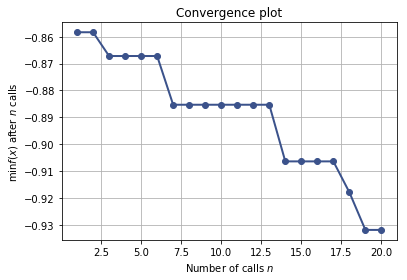

In [0]:
from skopt.plots import plot_convergence 

plot_convergence( search_result);

In [0]:
best_parameters = {k.name: x for k, x in zip(space, search_result.x)}
best_parameters

{'dp1': 0.1964026267773824,
 'lr': 0.00018993235374046812,
 'mp1': 2,
 'nd1': 262,
 'nf1': 72,
 'nf2': 107,
 'nf3': 512,
 'nk1': 7,
 'nk2': 8,
 'nk3': 5}

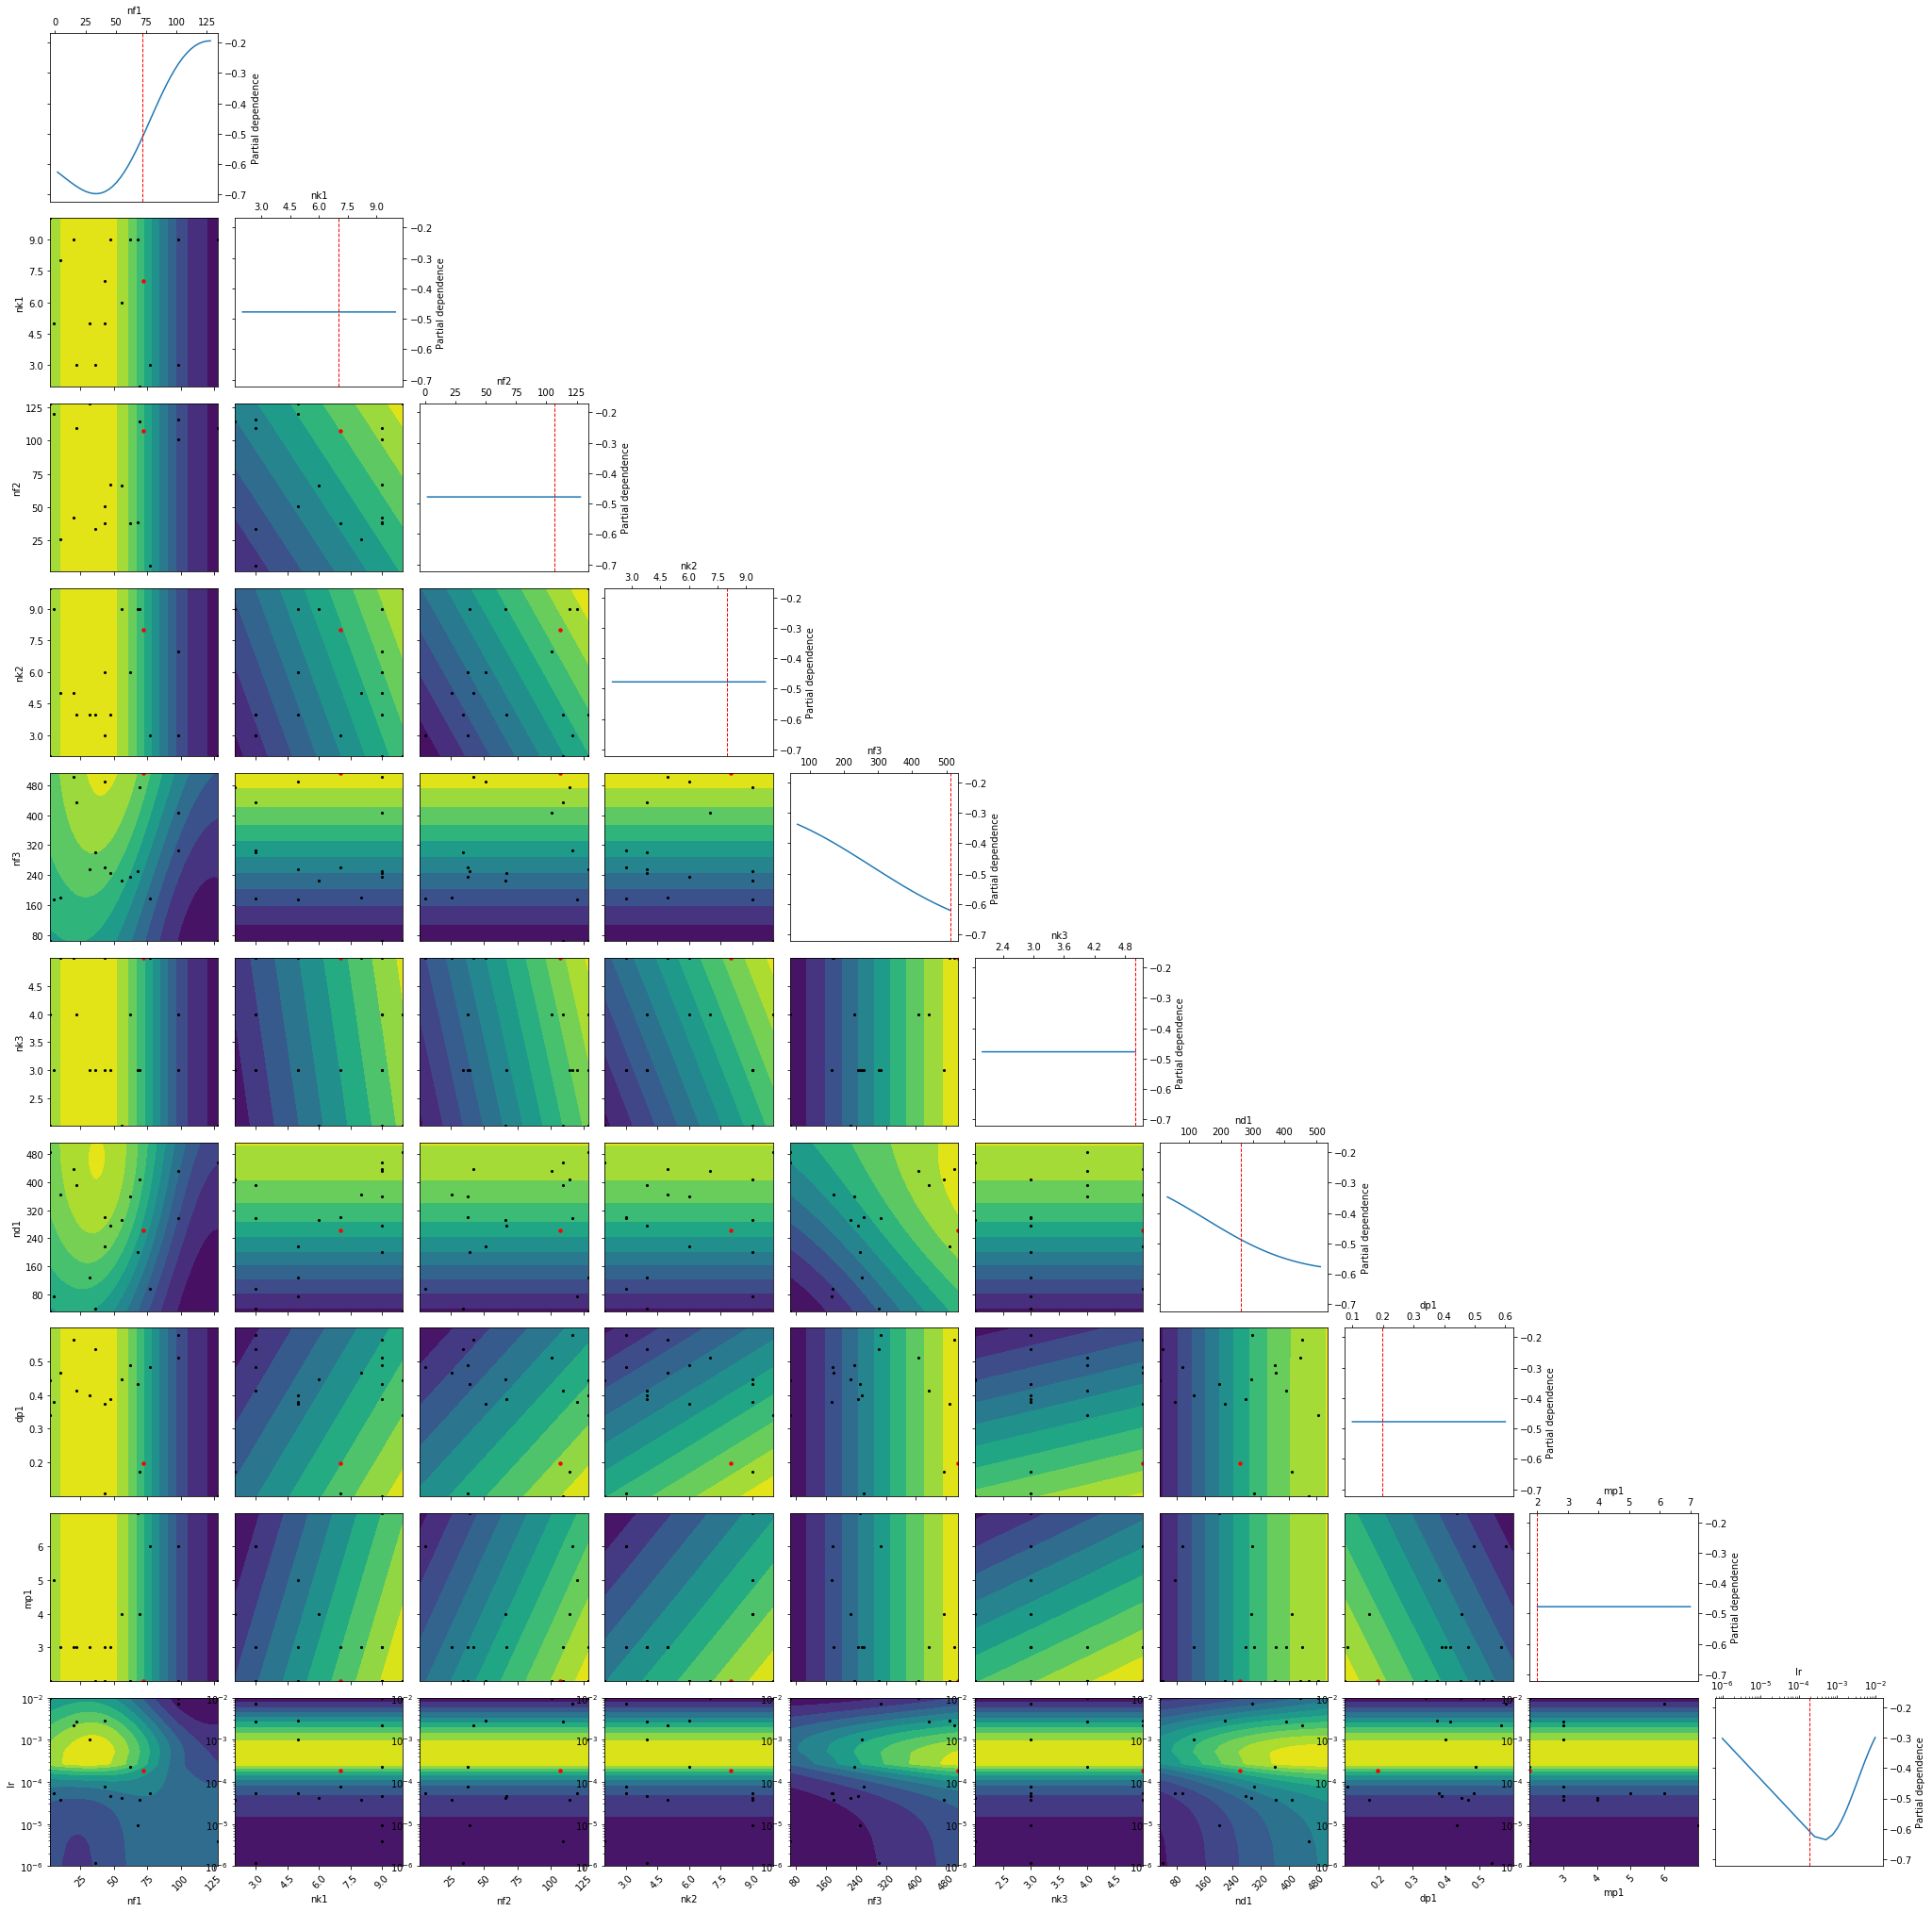

In [0]:
from skopt.plots import plot_objective
import matplotlib.pyplot as plt 

plot_objective(search_result, size=3, dimensions=[dim.name for dim in space])
plt.show()